In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import spearmanr
import glob
%matplotlib inline

%config InlineBackend.figure_format = 'svg'

from IPython.core.debugger import Pdb

# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

## Helper Functions

In [2]:
# Helper functions

def trial_label(x):
    """
    turns the feature into a string of all of the features in it
    so that we can find unique combinations
    of the following variables:
        R1 = first choice (1 or 2)
        R2 = second choice (1 or 2)
        RW = reward (0 or 1)
        S2 = second state (1 or 2)
        R1*/best_R1 = first choice that would have led to greatest pr(reward)
    """
    as_strings = [num.astype(str) for num in x]
    return "".join(as_strings)




def make_features(trials_data):
    """
    Data is input in the form:
        [trials x n_features]
    
    Data is turned into the form:
        [nTrials X index ]
    where index is a unique ID from corresponding to a unique
    combination of features
    """
    labeled_data = np.apply_along_axis(trial_label, 0, trials_data)
    combos = np.unique(labeled_data)
    string_to_index = dict(zip(combos, np.arange(len(combos))))
    map_to_index = np.vectorize(lambda x: string_to_index[x])
    mapped_data = map_to_index(labeled_data)
    return mapped_data


# HELPER FUNCTIONS TO COMPUTE PREDICTIVE INFORMATION
def get_new_features_sliding(x, w):
    """
    Returns new feature vector based on a desired sliding window
    x: vector of observations 
    w: sliding window size
    """
    n_feat = len(np.unique(x))
    base_feat = n_feat**(np.arange(w))
    new_features = np.array([np.dot(x[i-w:i], base_feat) for i in range(w,len(x))])
    
    return new_features

def get_marginal(x):
    """
    Helper function to compute and return marginal probability distribution for a 1d vector (x)
    """
    px = np.array([np.sum(x==xi) 
                      for xi in np.unique(x)])/len(x)
    return px

def get_joint(x, y):
    """
    Computes joint probability distribution between 1d vectors x and y
    """
    #  set up dictionary for joint distribution (x-->y-->freq)
    joint_x_y = {}
    
    for x_un in np.unique(x):
        joint_x_y[x_un] = dict(zip(np.unique(y), np.zeros(len(np.unique(y)))))
        
#    populate dictionary 
    for trial, x_val in enumerate(x):
        y_val = y[trial]
        joint_x_y[x_val][y_val] += 1
        
#   normalize to make distirbution  
    joint_sum = sum(sum(list(c.values())) for c in list(joint_x_y.values()))
    
    for key1 in joint_x_y:
        for key2 in joint_x_y[key1]:
            joint_x_y[key1][key2] /= joint_sum
            
    return joint_x_y

def mutual_inf(x, y):
    """
    Calculates the mutual information I(x;y)
    Assuming x,y are both [n x 1] dimensional
    """  
#     Calculate marginal distributions
    px = get_marginal(x)
    py = get_marginal(y)
    
    
    joint_x_y = get_joint(x,y)
# calculate mutual information
    mi = 0
    
    for n_x, x_un in enumerate(np.unique(x)):
        pxi = px[n_x] # p(x)
        
        for n_y, y_un in enumerate(np.unique(y)):
            pyi = py[n_y] # p(y)            
            
            joint_i = joint_x_y[x_un][y_un] # P(x,y)
            
            if ((pxi == 0) or (pyi == 0) or (joint_i ==0 )):
                continue
            else:
                mi += joint_i * np.log2(joint_i/(pxi*pyi))
                
    return mi


def deltaBound(ib_ipast,ib_ifuture,p_ipast,p_ifuture):
    ''' Function to calculate distance from the bound between an empirical IB and participant predictive info
    ib_ipast: ipast of empirical IB (x of convex hull)
    ib_ifuture: ifuture of empirical IB (y of convex hull)
    p_ipast: participant ipast (uncorrected)
    p_ifuture: participant ifuture (uncorrected)
    
    Returns participant ifuture minus the empirical bound (more negative = farther away from the bound)
    '''
    ind = np.argwhere(np.array(ib_ipast) > p_ipast)[0][0]
    slp = (ib_ifuture[ind]-ib_ifuture[ind-1])/(ib_ipast[ind]-ib_ipast[ind-1])
    intercept = ib_ifuture[ind]-(slp*ib_ipast[ind])
    #Return distance between participant Ifuture and interpolated bound - higher 
    return p_ifuture - ((p_ipast*slp)+intercept)

## Reading and Cleaning Data

The Data comes in from MATLAB and the conversion and formatting can be found in "DAW_DATA_main.ipynb"

In [3]:
data = np.load('data/DAW_MBMF/new_data.npy').item()



FileNotFoundError: [Errno 2] No such file or directory: 'data/new_data.npy'

## W value vs. Ipast and Ifuture

In [7]:
w_vals_1 = np.zeros(11)
ip_vals_1 = np.zeros((100,11))
if_vals_1 = np.zeros((100,11))

j=0
for w in data:
    w_vals_1[j] = w
    print(j)
    for i in range(100):
        model = data[w]
        keys = ['S2', 'R1', 'R2', 'Rw', 'best_R1']
        trials = np.vstack([model[key][i] for key in keys]) 
        features = make_features(trials)
        
        i_p = mutual_inf(features[:-2], model['R1'][i][2:])
        ip_vals_1[i, j] = i_p
        i_f = mutual_inf(model['R1'][i][:-1], features[1:])
        if_vals_1[i,j] = i_f
    j += 1



w_vals_2 = np.zeros(11)
ip_vals_2 = np.zeros((100,11))
if_vals_2 = np.zeros((100,11))

j=0
for w in data:
    w_vals_2[j] = w
    print(j)
    for i in range(100):
        model = data[w]
        keys = ['S2', 'R2', 'Rw', 'best_R1']
        trials = np.vstack([model[key][i] for key in keys]) 
        features = make_features(trials)
        
        i_p_2 = mutual_inf(features[:-2], model['R1'][i][2:])
        ip_vals_2[i, j] = i_p_2
        i_f_2 = mutual_inf(model['R1'][i][:-1], features[1:])
        if_vals_2[i,j] = i_f_2
    j += 1

0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9
10


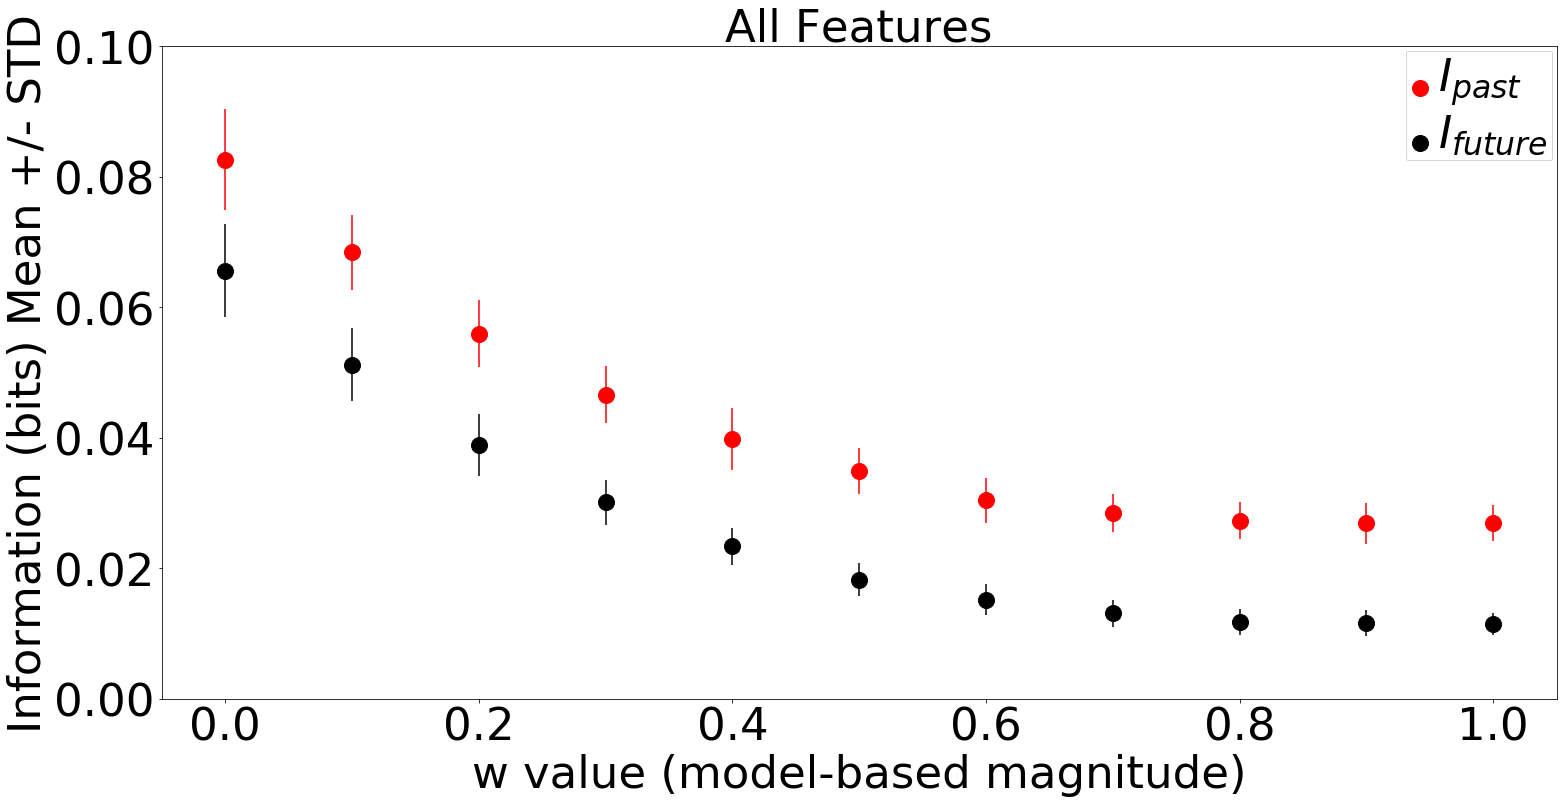

In [12]:
plt.figure(figsize=(25,12))

plt.plot(w_vals_1, np.mean(ip_vals_1,axis=0), 'ro', markersize=16, label='$I_{past}$')
plt.errorbar(w_vals_1,np.mean(ip_vals_1,axis=0),yerr=np.std(ip_vals_1,axis=0), ecolor = 'r', linestyle='')
plt.plot(w_vals_1, np.mean(if_vals_1,axis=0), 'ko', markersize=16, label='$I_{future}$')
plt.errorbar(w_vals_1,np.mean(if_vals_1,axis=0),yerr=np.std(if_vals_1,axis=0), ecolor= 'k',linestyle='')
plt.xlabel('w value (model-based magnitude)')
# xticks([])
plt.ylabel('Information (bits) Mean +/- STD')
plt.title('All Features')
# title('Full Features Vector')
plt.ylim([0,.1])
plt.legend()

ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()+ax.legend().get_texts()):
    item.set_fontsize(45)
  
"""
# to save, use plt.savefig()
can take in argument to change file type
"""

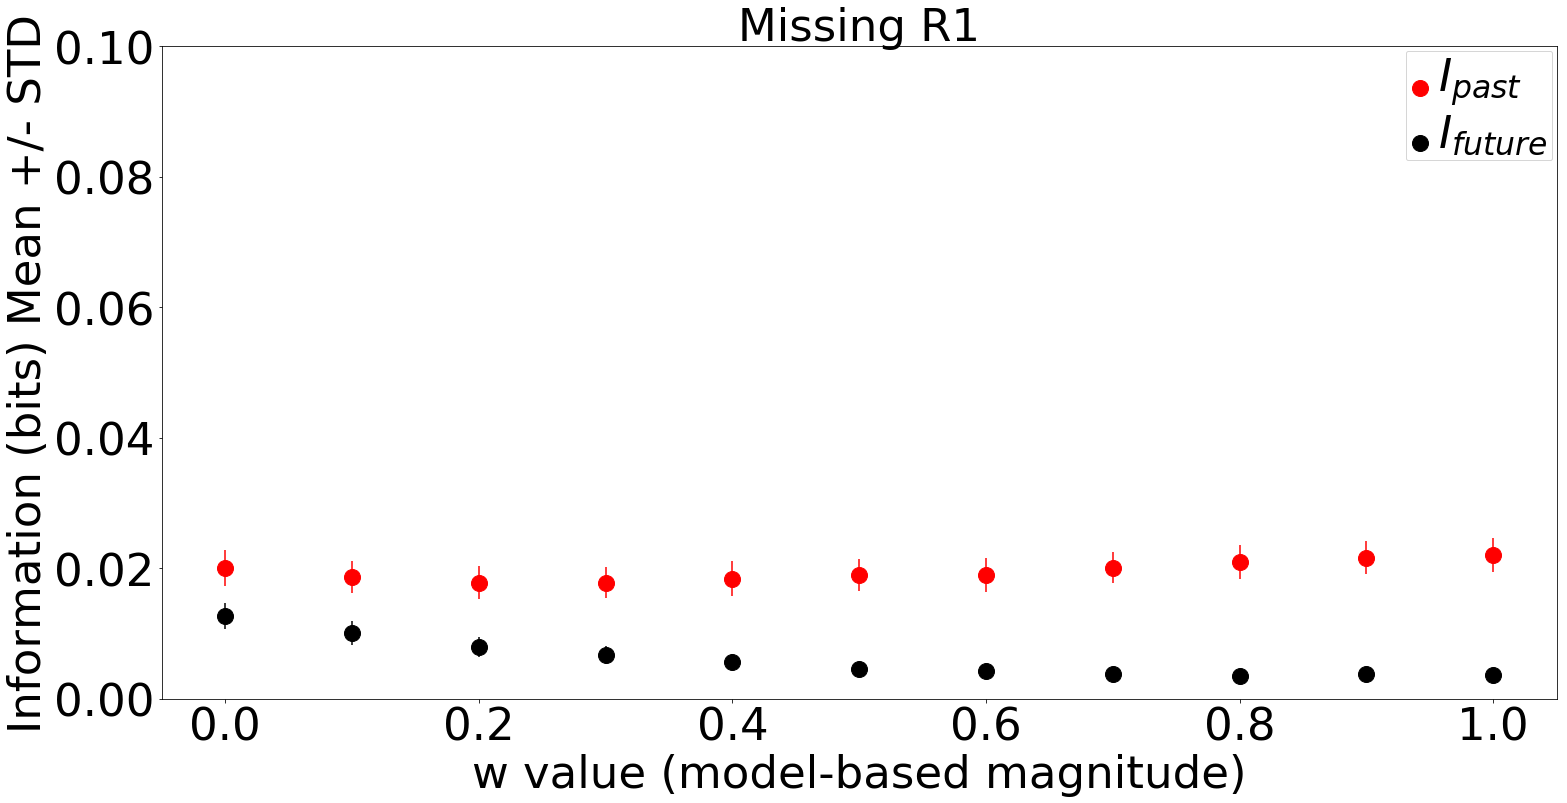

In [11]:
plt.figure(figsize=(25,12))

plt.plot(w_vals_2, np.mean(ip_vals_2,axis=0), 'ro', markersize=16, label='$I_{past}$')
plt.errorbar(w_vals_2,np.mean(ip_vals_2,axis=0),yerr=np.std(ip_vals_2,axis=0), ecolor = 'r', linestyle='')
plt.plot(w_vals_2, np.mean(if_vals_2,axis=0), 'ko', markersize=16, label='$I_{future}$')
plt.errorbar(w_vals_2,np.mean(if_vals_2,axis=0),yerr=np.std(if_vals_2,axis=0), ecolor= 'k',linestyle='')
plt.xlabel('w value (model-based magnitude)')
# xticks([])
plt.ylabel('Information (bits) Mean +/- STD')
plt.title('Missing R1')
# title('Full Features Vector')
plt.ylim([0,.1])
plt.legend()

ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()+ax.legend().get_texts()):
    item.set_fontsize(45)
    
    
"""
# to save, use plt.savefig()
can take in argument to change file type
"""

## Choice Variability

In [13]:
def var_main(read_data,n_simulations=100):


    w_to_probs= {}
    w_to_vars= {}

    for w in read_data:

        prob_r1_rew_vect = np.zeros(n_simulations)
        var_r1_rew_vect = np.zeros(n_simulations)
        prob_r1_no_rew_vect = np.zeros(n_simulations)
        var_r1_no_rew_vect = np.zeros(n_simulations)


        R1 = read_data[w]['R1']
        S2 = read_data[w]['S2']
        RW = read_data[w]['Rw']

        for sim in range(n_simulations):
            R1_offset = R1[sim,1:]
            S2_offset = S2[sim, :-1]
            RW_offset = RW[sim, :-1]

            """
            Right now, choice variability is computed using prob
            that R1 is the choice that gets you back to same S2. 
            We are using specifically S2=2 so R1=1 on the next trial,
            but the results were identical whether you use S2=1 and R1=2,
            or you combine all data into "same" vs. "differrent"
            """
            
            R1_masked = R1_offset[(S2_offset==2) & (RW_offset==1)]
            prob_r1_rew_vect[sim] = np.sum(R1_masked==1)/len(R1_masked)

            var_r1_rew_vect[sim] = prob_r1_rew_vect[sim]*len(R1_masked)*(1.0-prob_r1_rew_vect[sim])

            R1_masked = R1_offset[(S2_offset==2) & (RW_offset==0)]
            prob_r1_no_rew_vect[sim] = np.sum(R1_masked==1)/len(R1_masked)

            var_r1_no_rew_vect[sim] = prob_r1_no_rew_vect[sim]*len(R1_masked)*(1.0-prob_r1_no_rew_vect[sim])

        w_to_probs[w] = (prob_r1_rew_vect, prob_r1_no_rew_vect)
        w_to_vars[w] = (var_r1_rew_vect, var_r1_no_rew_vect)
    
    return (w_to_probs, w_to_vars) 



def plot_probs(w_to_probs, broad=False):
#     plt.figure()
    sorted_keys = sorted(w_to_probs.keys())
    plt.errorbar(sorted_keys, [np.mean(w_to_probs[key][0]) for key in sorted_keys],
                 yerr=[np.std(w_to_probs[key][0]) for key in sorted_keys], label='Rewarded')
    plt.errorbar(sorted_keys, [np.mean(w_to_probs[key][1]) for key in sorted_keys],
             yerr=[np.std(w_to_probs[key][1]) for key in sorted_keys], label='Not Rewarded')
    plt.ylim((.2, .8))
    plt.ylabel('Pr[R1]')
    
    if broad:
        s = 'Pr R1|S2=1 for BROAD reward'
    else:
        s= 'Probability of R1 being the choice that gets you back to same S2'
        
    plt.title(s)

    plt.xlabel('w value')
    plt.legend()
#     plt.show()
    
def plot_vars(w_to_vars, broad=False):
#     plt.figure()
    sorted_keys = sorted(w_to_vars.keys())
    plt.errorbar(sorted_keys, [np.mean(w_to_vars[key][0]) for key in sorted_keys],
                 yerr=[np.std(w_to_vars[key][0]) for key in sorted_keys], label='Rewarded')
    plt.errorbar(sorted_keys, [np.mean(w_to_vars[key][1]) for key in sorted_keys],
             yerr=[np.std(w_to_vars[key][1]) for key in sorted_keys], label='Not Rewarded')
    if broad:
        s = 'Var  R1|S2=1 for BROAD reward'
    else:
        s= 'Variance of R1 being the choice that gets you back to same S2'
    plt.ylabel('Var[R1]') 
    plt.title(s)
    plt.xlabel('w value')
    plt.legend()
#     plt.show()
    

In [16]:
prob,var = var_main(data)



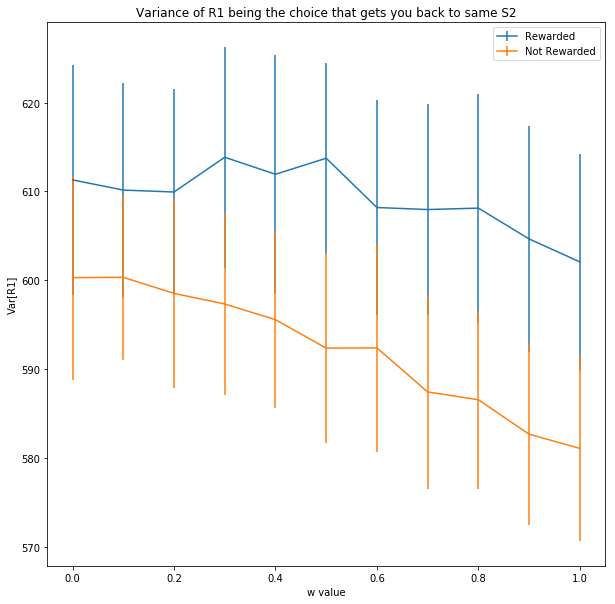

In [18]:
plt.figure(figsize=(10,10))

plot_vars(var, False)
# plt.savefig('choice_vars_1.png')

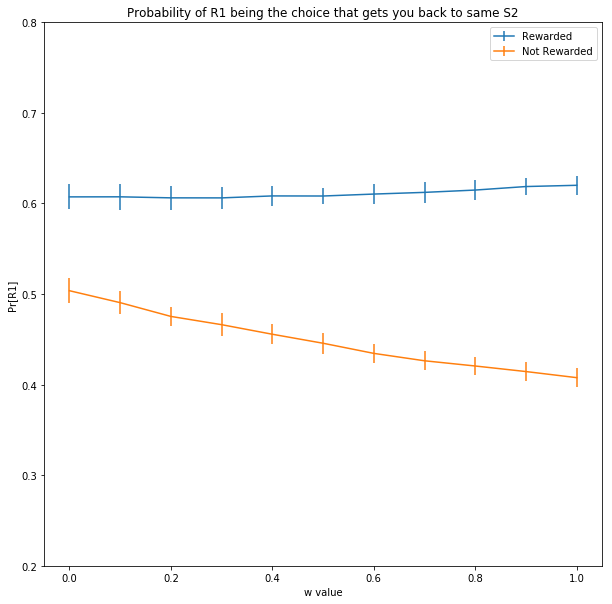

In [19]:
plt.figure(figsize=(10,10))

plot_probs(prob, False)
# plt.savefig('choice_vars_1.png')

## Distance from the Bound

## The Bounds

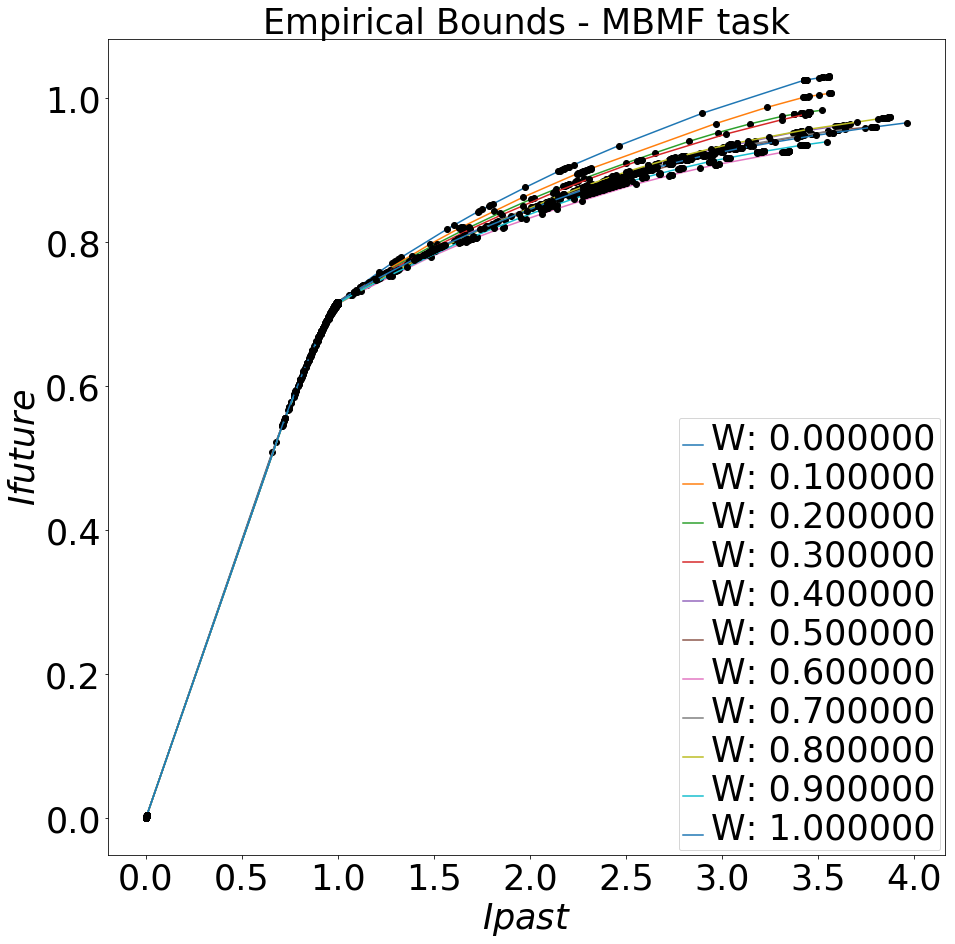

In [24]:
plt.figure(figsize=(15,15))

hull_names = sorted(glob.glob('./MBMF_bounds/*.npy'))

hulls = {}
for i,key in enumerate(np.arange(0.0,1.1,.1)):
#     if i%2 == 0:
    if True:
        hulls[key] = np.load(hull_names[i])
        hull = hulls[key]
        plt.plot(hull[:-1,0],hull[:-1,1],'-',label='W: %f'%key)
        plt.plot(hull[:-1,0],hull[:-1,1],'ok')
plt.xlabel('$Ipast$')
plt.ylabel('$Ifuture$')
plt.title('Empirical Bounds - MBMF task')
plt.legend()
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()+ax.legend().get_texts()):
    item.set_fontsize(35)
# plt.savefig('bounds')

## Reading Data

The data for this analysis is the SAME as the data above, but only takes one simulation per W value instead of 100

In [26]:
#Load data
read_data = np.load('data/DAW_DATA_FOR_CLUSTER.npy').item()


## Predictive Information

In [27]:
predInfo_raw = {}
predInfo_norm = {}
dbound_raw = {}
dbound_norm = {}
sat = {}
plt.figure(1)
for w in np.sort(list(read_data.keys())):
    print('Computing pred info %f...'%w)
    subject = read_data[w]
    keys = ['S2', 'R1', 'R2', 'Rw', 'best_R1']
    trials = np.vstack([subject[key] for key in keys])
    features = make_features(trials)
    resp = subject['R1']
    
    #Saturation point (mutual info between past and future feature)
    sat[w] = mutual_inf(features[:-1],features[1:])
    
    #Ipast and Ifuture
    predInfo_raw[w] = [mutual_inf(features[:-1],resp[1:]),mutual_inf(features[1:],resp[:-1])]
    predInfo_norm[w] = predInfo_raw[w]/sat[w]
    


    #Bound
    hull = hulls[w]
    dbound_raw[w] = deltaBound(np.flip(hull[:-1,0],0),np.flip(hull[:-1,1],0),predInfo_raw[w][0],predInfo_raw[w][1])
    hull_norm = hull/sat[w]
    print(predInfo_raw[w])
    dbound_norm[w] = deltaBound(np.flip(hull_norm[:-1,0],0),np.flip(hull_norm[:-1,1],0),predInfo_norm[w][0],predInfo_norm[w][1])
    
    #Plot
#     plot(predInfo[w][0],dbound[w],'o',label='W: %f'%w)
# ylabel('Distance from Bound')
# xlabel('Ipast')
# legend()




Computing pred info 0.000000...
[0.12255645876499133, 0.06875495850380652]
Computing pred info 0.100000...
[0.09821772742720582, 0.05700164439998327]
Computing pred info 0.200000...
[0.08090663565133607, 0.045663582150512326]
Computing pred info 0.300000...
[0.06837712835972815, 0.02975499147048883]
Computing pred info 0.400000...
[0.05600049864417946, 0.024059850704018514]
Computing pred info 0.500000...
[0.04393639872247295, 0.015147956998023722]
Computing pred info 0.600000...
[0.040942761382920294, 0.012425629076625734]
Computing pred info 0.700000...
[0.038161157795140344, 0.011912858764141335]
Computing pred info 0.800000...
[0.048735524949561994, 0.01579229561583523]
Computing pred info 0.900000...
[0.04007115340885149, 0.010165225894991171]
Computing pred info 1.000000...
[0.0399516632559717, 0.010299905736471751]


<Figure size 432x288 with 0 Axes>

In [28]:
ws = [w for w in np.sort(list(read_data.keys()))]
db = [dbound_norm[w] for w in ws]
ip = [predInfo_norm[w][0] for w in ws]

No handles with labels found to put in legend.


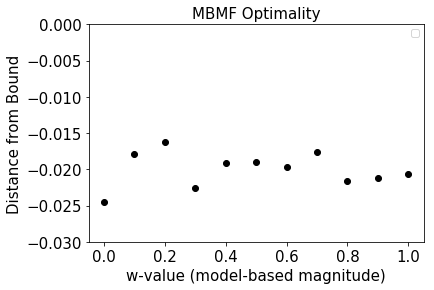

In [30]:
plt.plot(ws, db, 'ko')
plt.ylabel('Distance from Bound')
plt.xlabel('w-value (model-based magnitude)')
plt.title('MBMF Optimality')
plt.ylim([-.03, 0])
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()+ax.legend().get_texts()):
    item.set_fontsize(15)
# plt.savefig('dbound_ip')

No handles with labels found to put in legend.


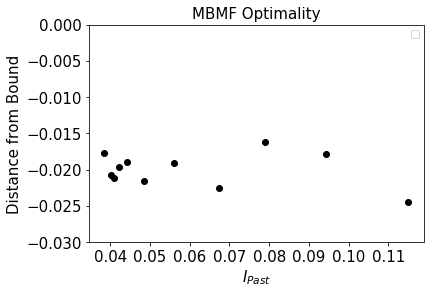

In [36]:

plt.ylabel('Distance from Bound')
plt.xlabel('$I_{Past}$')
plt.title('MBMF Optimality')
plt.plot(ip,db,'ko')
plt.ylim([-.03, 0])
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()+ax.legend().get_texts()):
    item.set_fontsize(15)
# plt.savefig('dbound_ip')

# Actual Human Data

### Helper Functions for Choice Variablity

In [5]:
def human_var(data_dict):
    w_to_probs= {}
    w_to_vars= {}

    for w in data_dict:

        R1 = data_dict[w]['R1']
        S2 = data_dict[w]['S2']
        RW = data_dict[w]['Rw']
        common = data_dict[w]['common']
        
        
        R1_adjusted = np.zeros(len(R1))
        R1_adjusted[common==1] = R1[common==1]
        
        def adjust(x):
            if (x==1):
                return 2
            else:
                return 1
        fxn = np.vectorize(adjust)
        R1_adjusted[common==0] = fxn(R1_adjusted[common==0])

        R1_adjusted = R1_adjusted[:-1]
        R1_offset = R1[1:]
        S2_offset = S2[:-1]
        RW_offset = RW[:-1]
        R_minus1 = R1[:-1]
        common_offset = common[:-1]
        
        same_choice = np.equal(R1_adjusted,R1_offset)
                
    
                    
        prob_r1_rew = np.sum(same_choice & (RW_offset==1))/np.sum(RW_offset==1)
        
        
        var_r1_rew = prob_r1_rew*(1.0-prob_r1_rew)

        
        prob_r1_no_rew = np.sum(same_choice & (RW_offset==0))/np.sum(RW_offset==0)

        var_r1_no_rew = prob_r1_no_rew*(1.0-prob_r1_no_rew)

        
        
#         same_choice = np.equal(R_minus1, R1_offset)
        
#         conditional_n = np.sum(((common_offset==1)& (RW_offset==1)))
#         prob_r1_rew = np.sum(((same_choice) & (common_offset==1)& (RW_offset==1)))/conditional_n
                            
            
#         var_r1_rew = prob_r1_rew*(1.0-prob_r1_rew)
        
#         conditional_n = np.sum(((common_offset==1)& (RW_offset==0)))
#         prob_r1_no_rew = np.sum(((same_choice) & (common_offset==1)& (RW_offset==0)))/conditional_n
            
#         var_r1_no_rew = prob_r1_rew*(1.0-prob_r1_no_rew)
        
        w_to_probs[w] = (prob_r1_rew, prob_r1_no_rew)
        w_to_vars[w] = (var_r1_rew, var_r1_no_rew)
        
        
#         # given reward
#         common_rewarded = common_offset[RW_offset==1]
#         R_minus1_rewarded = R_minus1[RW_offset==1]
#         R1_offset_rewarded = R1_offset[RW_offset==1]
# #         S2_offset_rewarded = S2_offset[RW_offset==1]
        
#         # same choice
#         same_choice = np.equal(R_minus1_rewarded, R1_offset_rewarded).astype(int)
#         prob_r1_rew = np.sum(((same_choice==1)&(common_rewarded==1)))/len(same_choice)
#         prob_r1_rew = np.sum(((S2_rewarded==2)&(R1_rewarded==2))|((S2_rewarded==1)&(R1_rewarded==1)))/len(R1_rewarded)
        
#         R1_masked = R1_offset[(S2_offset==2) & (RW_offset==1)]
#         prob_r1_rew = np.sum(R1_masked==2)/len(R1_masked)

#         var_r1_rew = prob_r1_rew*len(same_choice)*(1.0-prob_r1_rew)
        
        # not given reward
#         common_not_rewarded = common_offset[RW_offset==0]
#         R_minus1_not_rewarded = R_minus1[RW_offset==0]
#         R1_offset_not_rewarded = R1_offset[RW_offset==0]
# #         S2_not_rewarded = S2_offset[RW_offset==0]
# #         prob_r1_no_rew = np.sum(((S2_not_rewarded==2)&(R1_not_rewarded==2))|((S2_not_rewarded==1)&(R1_not_rewarded==1)))/len(R1_not_rewarded)
# # same choice
#         same_choice_nr = np.equal(R_minus1_not_rewarded, R1_offset_not_rewarded).astype(int)
#         prob_r1_no_rew = np.sum(((same_choice_nr==1)&(common_not_rewarded==1)))/len(same_choice_nr)

#         var_r1_no_rew = prob_r1_no_rew*len(same_choice_nr)*(1.0-prob_r1_no_rew)

#         w_to_probs[w] = (prob_r1_rew, prob_r1_no_rew)
#         w_to_vars[w] = (var_r1_rew, var_r1_no_rew)
    
    return (w_to_probs, w_to_vars)

In [2]:
data_in = np.load('DAW_human_data.npy').item()
data_in.keys()

dict_keys(['trial_data', 'interaction', 'maineffect', 'subject_fits'])

In [3]:
human_dict = {}
# subjects x trials x [R1,RW,S2]

trial_data = data_in['trial_data']
w_vals = np.squeeze(data_in['subject_fits'])
interaction_vals = np.squeeze(data_in['interaction'])
maineffect_vals = np.squeeze(data_in['maineffect'])

for i_sub in range(len(w_vals)):
    human_dict[w_vals[i_sub]] = {}
    human_dict[w_vals[i_sub]]['R1'] = trial_data[i_sub,:,0]
    human_dict[w_vals[i_sub]]['Rw'] = trial_data[i_sub,:,1]
    human_dict[w_vals[i_sub]]['S2'] = trial_data[i_sub,:,2]
    human_dict[w_vals[i_sub]]['common'] = trial_data[i_sub,:,3]
    
n_subjects = len(w_vals)

(array([80.,  4.,  3.,  6.,  4.,  7.,  3.,  4.,  7.,  8.,  7.,  6.,  6.,
        10.,  2.,  7.,  7.,  3.,  4., 19.]),
 array([2.63817383e-09, 5.00000024e-02, 1.00000002e-01, 1.50000002e-01,
        2.00000002e-01, 2.50000001e-01, 3.00000001e-01, 3.50000001e-01,
        4.00000000e-01, 4.50000000e-01, 5.00000000e-01, 5.50000000e-01,
        5.99999999e-01, 6.49999999e-01, 6.99999999e-01, 7.49999999e-01,
        7.99999998e-01, 8.49999998e-01, 8.99999998e-01, 9.49999998e-01,
        9.99999997e-01]),
 <a list of 20 Patch objects>)

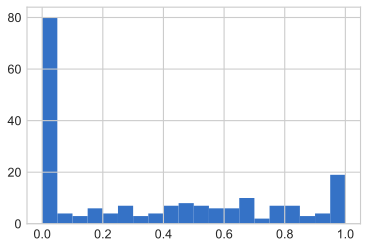

In [4]:
plt.hist(w_vals,20)

### Subject Variability

#### human_probs dictionary
**keys**: w _value

**values**: (probability given reward, probability given no reward)


#### human_vars dictionary

**keys**: w _value

**values**: (variance given reward, variance given no reward)

In [10]:
human_probs, human_vars = human_var(human_dict)

### Other Subject Data Terms

**w_vals**: w values computed via regression by the MBMF paper people 

**trial_data**: full data set for each subject

**interaction_vals**: interaction term per subject

**maineffect_vals**: main effect term per subject

In [12]:
np.shape(w_vals)

(197,)

In [13]:
np.shape(trial_data)

(197, 125, 4)

In [14]:
np.shape(interaction_vals)

(197,)

In [15]:
np.shape(maineffect_vals)

(197,)

In [21]:
len(list(human_probs.keys()))

197